In [5]:
from __future__ import print_function, division

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess


from IPython.display import HTML



import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings


## Data

Read data and concatenate into one dataset.

level 0 = Surface

level 110 = TOA

(our data is in the order TOA-->Surface)

In [7]:
###### load atm and gas files into dataframes ######
atm_df = pd.concat(pd.read_excel('../schmit_data/schmit_compiled_temp_data_final.xlsx', #read in atm data
                                 sheet_name=None,   # import all sheets in the excel
                                 na_values=np.nan), # convert nan to numpy nan values
                   axis=0) #concatenate along 0th axis
gas_df = pd.concat(pd.read_excel('../schmit_data/schmit_compiled_gas_data.xlsx', #read in gas data
                                 sheet_name=None,   # import all sheets in the excel
                                 na_values=np.nan), # convert nan to numpy nan values
                   axis=0) #concatenate along 0th axis and flip
df = pd.concat([atm_df,gas_df],axis=1, sort=True) #concatenate gas and atm data into one dataframe

###### create our overall dataset and rename coordinates #####

ds = xr.Dataset(df).unstack() #create dataset and unstack our coordinates
ds = ds.rename({'dim_0_level_0': 'month'}) #rename coordinate
ds = ds.rename({'dim_0_level_1': 'level'}) #rename coordinate
for var_idx, var_name in enumerate(ds.variables): #transpose our data
    ds[var_name] = ds[var_name].transpose()
ds['spec_humidity']=(ds['H2O']/(1+ds['H2O'])) #add in specific humidity
ds = ds.reindex(level=ds.level[::-1]) #reindex our data so it reads from top to bottom
ds.__delitem__('CO2') #delete unused variables
ds.__delitem__('CO') #delete unused variables
ds.__delitem__('CH4') #delete unused variables
ds.__delitem__('Height') #delete unused variables
ds['CO2_list'] = np.array([100.,200.,380.,760.,1000.,1500.])/(1e6) #list of CO2 values we will use

ds.attrs['name'] = 'all'

In [8]:
######### calculate mean insolation for each month and add to dataset #########

month_days = [31,28,31,30,31,30,31,31,30,31,30,31] #list of the number of days in a month
day_of_month = [
    np.cumsum(month_days) - np.array(month_days),
    np.cumsum(month_days)
] #list of first and last day of each month
day_num = np.arange(1,366) #number of days in a year
month_num  = np.arange(0,12) #number of months in a year

insolation = np.zeros(len(day_num)) #insolation for each day
monthly_insol = np.zeros(len(month_num)) #insolation for each month
for day in day_num: #calculate daily insolation
    insolation[day-1] = daily_insolation(lat = -90, day = day)
for month in month_num: #calculate monthly mean insolation
    monthly_insol[month] = insolation[day_of_month[0][month]:day_of_month[1][month]].mean()
ds['monthly_insolation'] = xr.DataArray(data = monthly_insol, dims = 'month') #add into our dataset

In [17]:
####### cut dataset to bottom 60km #########

ds_strat_lev = 96
ds_strat = ds.sel(level=slice(ds_strat_lev,0))
ds_strat.attrs['name'] = 'strat'

# Climlab

#### Just testing with the stratosphere--trying to get to loops through the stratosphere and no stratosphere to set up properly in the turbulence class, until then just working with one

In [18]:
###### create a Turbulence class #######
class Turbulence(TimeDependentProcess):
    #class turbulence that decays with height computed from:
    # theta = Tatm(P0/Patm)^R/Cp
    # k0 = Net surface flux/(dtheta/dz) at surface 
    # ka = k0*exp(-z/d) in atmosphere
    # -ka * dtheta/dz is turbulent flux in the atmosphere 
    
    def __init__(self, **kwargs):
        #define initial state
        super(Turbulence, self).__init__(**kwargs) #initialize our model
        self.experiment = experiment #name the experiment as part of the model
        self.time_type = 'explicit' #explicit time calculations
        ### define new levels
        #n+1 pressure level (lev_boundsin climlab) reworked so that we are no longer using 0 and 1000 as our TOA and surface
        self.lev_bounds[0] = self.lev_bounds[1]-2*(self.lev_bounds[1] - self.lev[0])
        self.lev_bounds[-1] = self.lev_bounds[-2]+2*(self.lev[-1] - self.lev_bounds[-2])
        #altitude (n)
        self._z = (self.experiment['Altitude'].sel(month = m)- self.experiment['Altitude'].sel(month = m).isel(level = -1))
        #altitude bounds (n)
        self._z_bounds = np.zeros(len(state['Tatm']) +1)
        for n in range(len(state['Tatm'])-1):
            self._z_bounds[n+1] = ((self._z[n]+self._z[n+1])/2)
        self._z_bounds[0] = (ds['Altitude'].sel(month = m).sel(level = ds_strat_lev +1) + experiment['Altitude'].sel(month = m).sel(level = len(experiment['Altitude'])-1))/2 - experiment['Altitude'].sel(month = m).isel(level = -1)
        self._z_bounds[-1] = (self._z[-1]+self._z[-2])/2        ### calculate turbulent flux
        #surface flux (LW + SW)
        self._total_sfc_flux_init = (rad.diagnostics['SW_sfc_clr']- rad.diagnostics['LW_sfc_clr']) #W/m^2
        #gas constant / specific heat of air
        R = 287 #gas constant of air J/kg*K (at 250 K)
        cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)
        density = 1.05 #density of air kg/m^3
        self.R_cp = R/cp_air 
        self._theta_init = np.zeros(len(state['Tatm']) +1)
        self._theta_init[:-1] = self.state['Tatm']*(np.asarray(experiment['Pressure'].sel(month = m).isel(level = -1))/self.lev)**(self.R_cp)#K
        self._theta_init[-1] = self.state['Ts']*(np.asarray(experiment['Pressure'].sel(month = m).isel(level = -1))/np.asarray(experiment['Pressure'].sel(month = m).isel(level = -1)))**(self.R_cp) #K
        #dtheta_dz_init (just need the first value of dtheta/dz)
        self._dtheta_dz_surf_init = (np.diff(self._theta_init)/np.diff(self._z))[-1] #K/m
        #surface diffk (m2/s)
        self._surface_diffk = (-self._total_sfc_flux_init/self._dtheta_dz_surf_init)/(density*cp_air) #m^2/s
        #atmospheric diffk (n+1)
        scale_factor = 100 #m
        self._atm_diffk = self._surface_diffk * (np.exp(-self._z_bounds/scale_factor)) #m^2/s
        

    def _compute(self):
        #constants
        cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)
        density = 1.05 #density of air kg/m^3
        #surface flux (LW + SW)
        self._total_sfc_flux = (rad.diagnostics['SW_sfc_clr']- rad.diagnostics['LW_sfc_clr']) #W/m^2
        #theta (length of n)
        self._theta = np.zeros(len(state['Tatm']) +1)
        self._theta[:-1] = self.state['Tatm']*(np.asarray(experiment['Pressure'].sel(month = m).isel(level = -1))/self.lev)**(self.R_cp)#K
        self._theta[-1] = self.state['Ts']*(np.asarray(experiment['Pressure'].sel(month = m).isel(level = -1))/np.asarray(experiment['Pressure'].sel(month = m).isel(level = -1)))**(self.R_cp) #K        
        #dtheta_dz_init (length of n+1)
        self._dtheta_dz = np.zeros(len(state['Tatm']) +1)
        self._dtheta_dz[1:] = np.diff(self._theta)/np.diff(self._z)
        self._dtheta_dz[0] =  0 #TOA flux is zero
        #calculate the atmospheric turbulent flux
        self._atm_turbulent_flux = -self._atm_diffk * self._dtheta_dz #K*m/s
        #calculate/prescribe surface turbulent flux
        self._sfc_turbulent_flux = self._total_sfc_flux/(cp_air*density) #K*m/s
        # calculate heating rate (flux convergence) from flux and convert into K/day (which is the heating rate output in climlab)
        self._atm_hr = (np.diff(self._atm_turbulent_flux)/np.diff(self._z_bounds)) * climlab.constants.seconds_per_day #K/day
        self._sfc_hr= ((np.asarray(self._atm_turbulent_flux[-1])-np.asarray(self._sfc_turbulent_flux))/(np.asarray(self._z_bounds[-1])-np.asarray(self._z[-1])) * climlab.constants.seconds_per_day) #K/day
        self._hr = np.concatenate([ram.subprocess.Turbulence._atm_hr,ram.subprocess.Turbulence._sfc_hr])        
        tendencies = {'Tatm' : self._atm_hr, 'Ts' : self._sfc_hr}
        
        # check that CFL condition is met
        self._CFL = self._surface_diffk*(self.time['timestep']/(np.diff(self._z_bounds)**2))[-1] 
        if self._CFL > 1.:
            warnings.warn(f"CFL Condition not met, {self._CFL}, timestep too large or lower level z difference too small for {m}, CO2 {CO2} kg/kg")
        return tendencies

In [19]:
####### set up climlab ########

months = (np.asarray(ds['month'])) #list of months
exp_list = [ds_strat] #list of experiments
albedo = .8 
timestep = 20. 

#set up the radiative-advective model (ram)
ram_dict = {} #create our ram_dict for the output of each instance of ram (2 experiments x 6 CO2 levels x 12 months)
for experiment in exp_list:
    ram_dict[experiment.name] = {}
    for CO2 in experiment['CO2_list'].values:
        ram_dict[experiment.name][CO2] = {}
        for m in months:
            ram_dict[experiment.name][CO2][m] = {}
            ###create ram state, radiation model, and TimeDepedent ram model instance
            
            #create two domains: atm and surface
            sfc, atm=climlab.domain.single_column(lev=experiment['Pressure'].sel(month=m).isel(level = slice(0,-1)).values);
            #create an atmospheric state
            state = AttrDict()
            #set up a surface temperature profile 
            T_s=climlab.Field(experiment['Temperature'].isel(level=-1).sel(month=m).values, domain=sfc);
            state['Ts']=T_s #K
            #set up an atmospheric temperature profile
            T_atm=climlab.Field(experiment['Temperature'].sel(month=m).isel(level = slice(0,-1)).values, domain=atm);
            state['Tatm']=T_atm #K
                        
            #radiation model setup
            rad = climlab.radiation.RRTMG(name='Radiation(all gases)', state = state,
                                              specific_humidity = experiment['spec_humidity'].sel(month = m).isel(level = slice(0,-1)).values,
                                              albedo = albedo,
                                              timestep = timestep,
                                              ozone_file = None
                                              )
            rad.absorber_vmr['O3'] = experiment['O3'].sel(month = m).isel(level = slice(0,-1)).values #kg/kg
            rad.absorber_vmr['CO2'] = CO2 #kg/kg
            #create ram
            ram = climlab.TimeDependentProcess(state = state, timestep = timestep)
            #add latitude axis
            lat = climlab.domain.axis.Axis(axis_type='lat', points=-90.)
            ram.domains['Ts'].axes['lat'] = lat
            #add radiation
            ram.add_subprocess('Radiation', rad)
            #solar insolation model setup (fixed insolation for each month)
            insmodel = FixedInsolation(S0 = ds_strat['monthly_insolation'].sel(month = m).values, domains=ram.domains['Ts'], timestep = timestep) #input mean insolation for each month as a 'fixed insolation'
            #add insolation
            ram.add_subprocess('insolation', insmodel) #add insolation subprocess
            #compute ram
            ram.compute()
            #turbulence model setup (coupled to rad model, experiment, and month)
            turb = Turbulence(name = 'Turbulence', state=state, rad = rad, month = m, experiment = experiment, timestep = timestep)
            #add turbulence
            ram.add_subprocess('Turbulence', turb) #add insolation subprocess
            #compute ram
            ram.compute()
            #advective model setup (coupled to rad model)
            adv = climlab.process.external_forcing.ExternalForcing(state = state, turb = turb, ram = ram)
            adv.forcing_tendencies['Tatm'] = -((np.asarray(ram.TdotSW_clr - ram.TdotLW_clr) - turb._atm_hr))
            #add advection
            ram.add_subprocess('Advection', adv)
            #compute ram
            ram.compute()
            #add to dictionary
            ram_dict[experiment.name][CO2][m] = ram


In [20]:
ram_dict[experiment.name][CO2][m].state['Ts']


Field([245.52])

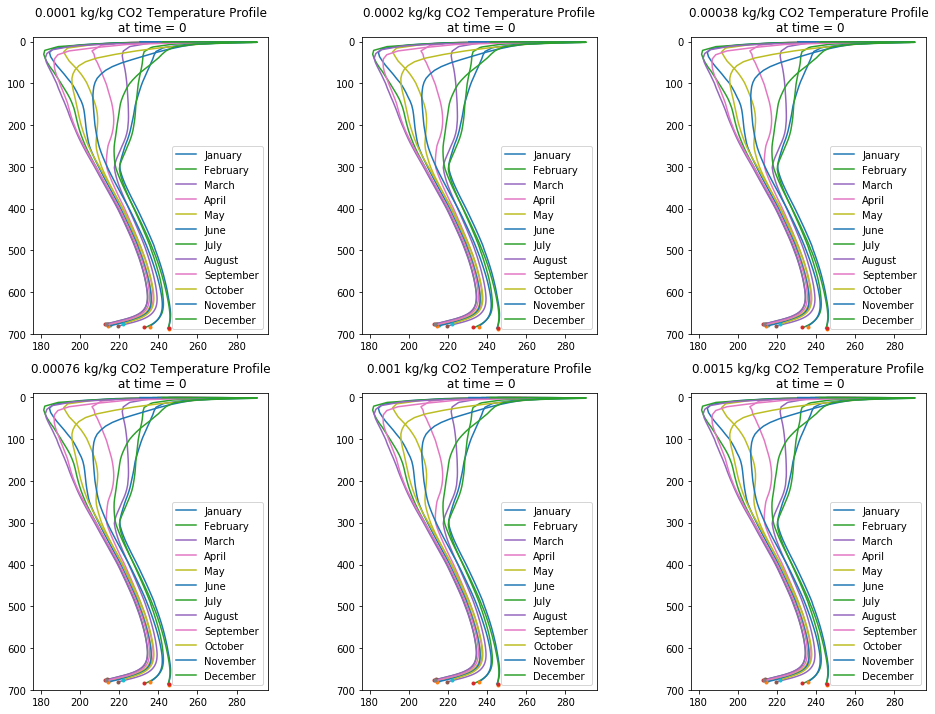

In [24]:
##### plot our initial timestep #####
fig = plt.figure(figsize = [16,12])
fig.subplots_adjust(hspace=.2, wspace=.4)
for idx, CO2 in enumerate(experiment['CO2_list'].values):
    ax = plt.subplot(2, 3, idx+1)
    plt.title(f'{CO2} kg/kg CO2 Temperature Profile\n at time = {ram_dict[experiment.name][CO2][m].time["steps"]}')
    for experiment in exp_list:
        for m in months:
            ax.plot(ram_dict[experiment.name][CO2][m].state['Tatm'], ram_dict[experiment.name][CO2][m].lev, label = f'{m}')
            ax.plot(ram_dict[experiment.name][CO2][m].state['Ts'], experiment['Pressure'].sel(month = m).isel(level = -1), '.')            
            ax.set_ylim([700,-10])
        plt.legend()

In [22]:
#### plot diagnostics to see turbulence, theta, dtheta/dz ####
def plot_diagnostics(experiment, CO2, month):
    fig, ax = plt.subplots(4,2,figsize = (14,14), constrained_layout=True)
    fig.suptitle(month, fontsize =16)
    ax[0,0].plot(ram_dict[experiment][CO2][month].subprocess.Turbulence._atm_diffk, ram_dict[experiment][CO2][month].subprocess.Turbulence._z_bounds) 
    ax[0,0].set_title('Atmospheric Kappa (m^2/s)')
    ax[0,0].set_xlabel('Kappa (m^2/s)')
    ax[0,0].set_ylabel('Altitude (m)')
    
    ax[0,1].plot(ram_dict[experiment][CO2][month].subprocess.Turbulence._theta_init, ram_dict[experiment][CO2][month].subprocess.Turbulence._z)
    ax[0,1].set_title('Theta (K)')
    ax[0,1].set_xlabel('Theta (K)')
    ax[0,1].set_ylabel('Altitude (m)')

    ax[1,0].plot(ram_dict[experiment][CO2][month].subprocess.Turbulence._dtheta_dz, ram_dict[experiment][CO2][month].subprocess.Turbulence._z_bounds)
    ax[1,0].set_title('dtheta/dz (K/m)')
    ax[1,0].set_xlabel('dtheta/dz (K/m)')
    ax[1,0].set_ylabel('Altitude (m)')
    
    ax[1,1].plot(ram_dict[experiment][CO2][month].subprocess.Advection.forcing_tendencies['Tatm'], ram_dict[experiment][CO2][month].subprocess.Turbulence._z[:-1])
    ax[1,1].set_title('Advective Heating Rate (K/day)')
    ax[1,1].set_xlabel('Advection (K/day)')
    ax[1,1].set_ylabel('Altitude (m)')
    
    ax[2,1].plot(ram_dict[experiment][CO2][month].subprocess.Turbulence._hr, ram_dict[experiment][CO2][month].subprocess.Turbulence._z)
    ax[2,1].set_title('Turbulent Heating Rate (K/day)')
    ax[2,1].set_xlabel('Turbulent Heating Rate (K/day)')
    ax[2,1].set_ylabel('Altitude (m)')

    ax[2,0].plot((ram_dict[experiment][CO2][month].TdotSW_clr-ram_dict[experiment][CO2][month].TdotLW_clr), ram_dict[experiment][CO2][month].subprocess.Turbulence._z[:-1])
    ax[2,0].set_title('Radiative Heating Rate (K/day)')
    ax[2,0].set_xlabel('Radiative Heating Rate (K/day)')
    ax[2,0].set_ylabel('Altitude (m)')
    
    ax[3,0].plot((ram_dict[experiment][CO2][month].TdotLW_clr), ram_dict[experiment][CO2][month].subprocess.Turbulence._z[:-1])
    ax[3,0].set_title('LW Heating Rate (K/day)')
    ax[3,0].set_xlabel('Heating Rate (K/day)')
    ax[3,0].set_ylabel('Altitude (m)')
    
    ax[3,1].plot((ram_dict[experiment][CO2][month].TdotSW_clr), ram_dict[experiment][CO2][month].subprocess.Turbulence._z[:-1])
    ax[3,1].set_title('SW Heating Rate (K/day)')
    ax[3,1].set_xlabel('Heating Rate (K/day)')
    ax[3,1].set_ylabel('Altitude (m)')

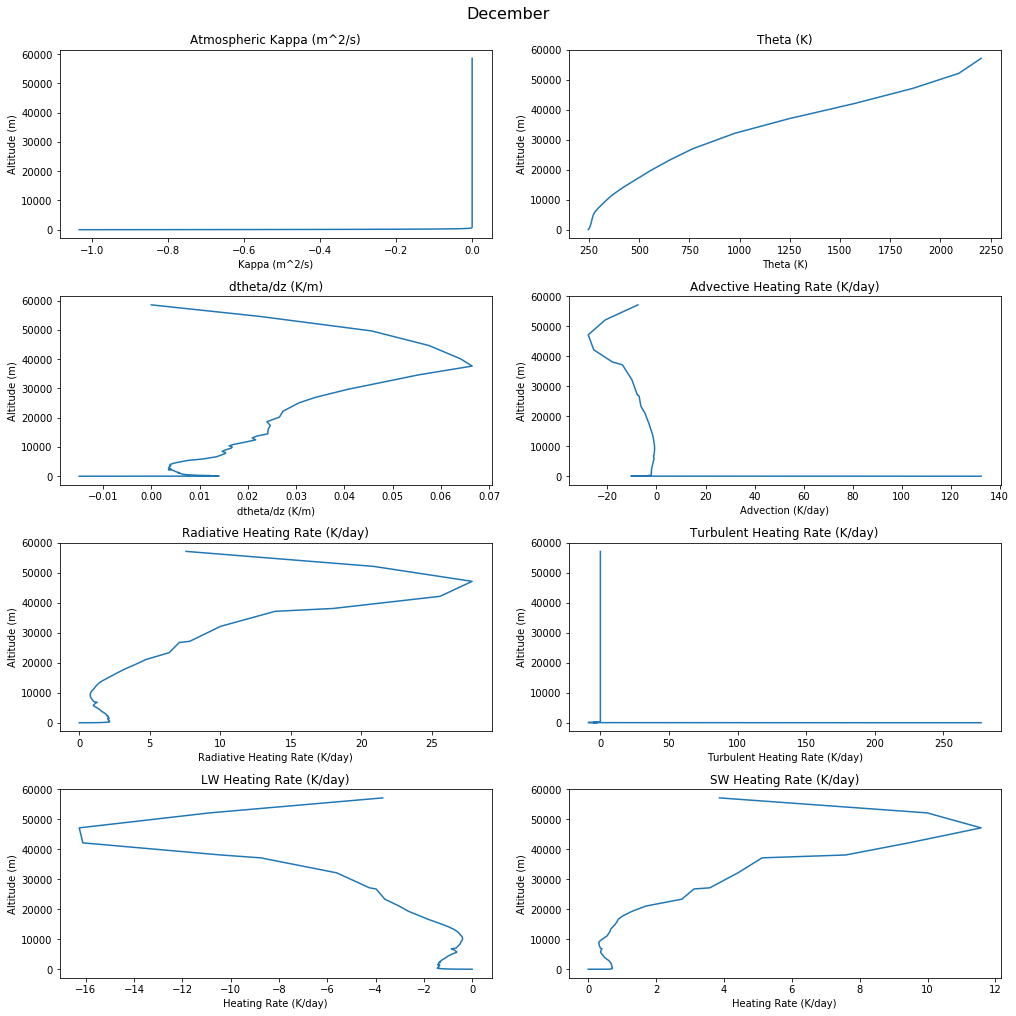

In [23]:
month = 'December'
plot_diagnostics('strat', 0.00038, month)
#plt.savefig('../figures/March_380ppm_strat.png', bbox_inches = 'tight', dpi =100)

# Timestep forward

In [178]:
for experiment in exp_list:
    for CO2 in experiment['CO2_list'].values:
        for m in months:
            ram_dict[experiment.name][CO2][m].step_forward()

In [179]:
ram_dict[experiment.name][CO2][m].state['Ts']

Field([-839.73546005])

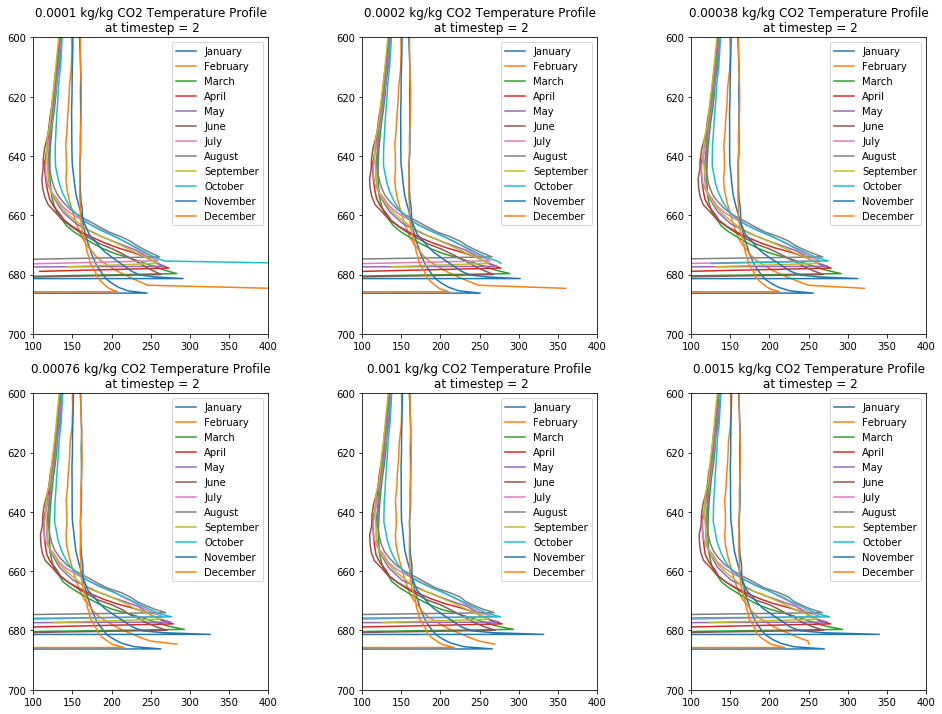

In [180]:
##### plot our initial timestep #####
fig = plt.figure(figsize = [16,12])
fig.subplots_adjust(hspace=.2, wspace=.4)
for idx, CO2 in enumerate(experiment['CO2_list'].values):
    ax = plt.subplot(2, 3, idx+1)
    plt.title(f'{CO2} kg/kg CO2 Temperature Profile\n at timestep = {ram_dict[experiment.name][CO2][m].time["steps"]}')
    for experiment in exp_list:
        for m in months:
            ax.plot(ram_dict[experiment.name][CO2][m].state['Tatm'], ram_dict[experiment.name][CO2][m].lev, label = f'{m}')
            ax.set_ylim([700,600])
            ax.set_xlim([100,400])
        plt.legend()

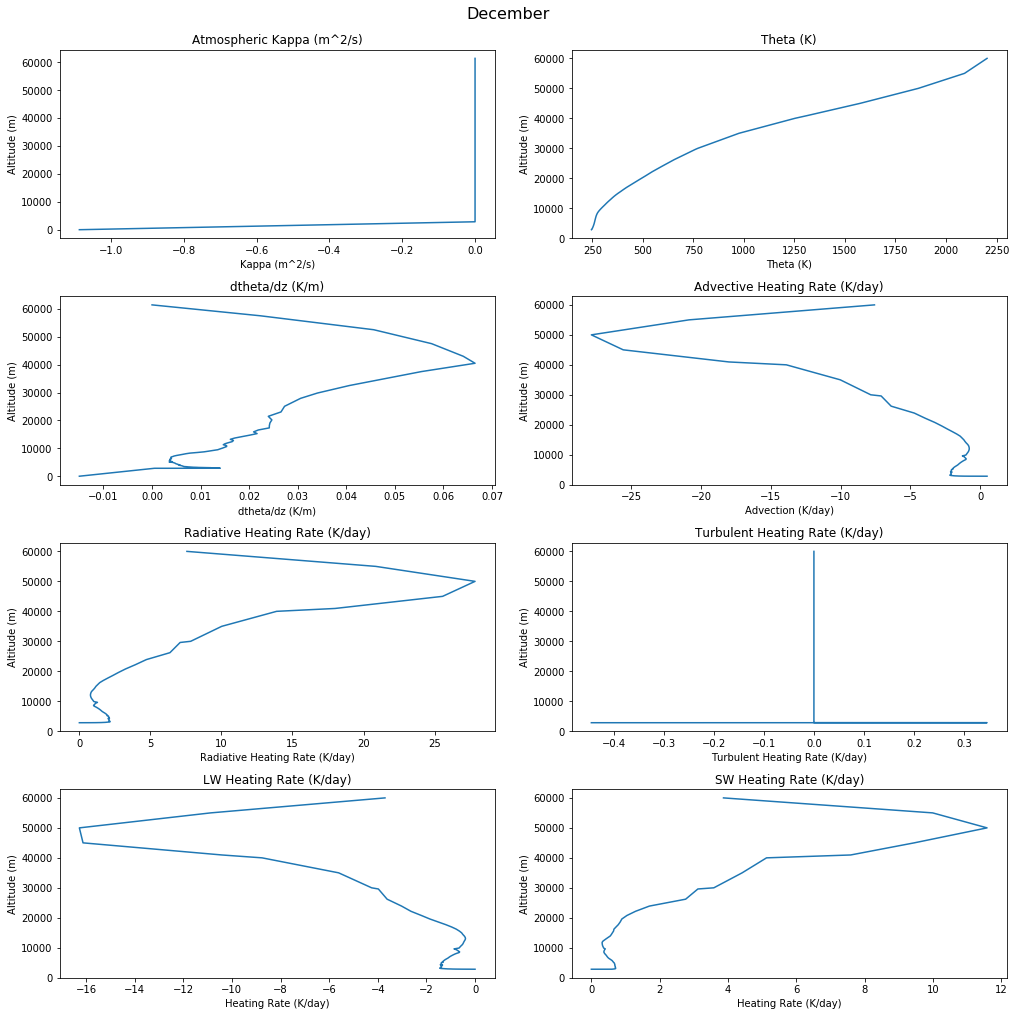

In [177]:
plot_diagnostics('strat', 0.00038, month)
#plt.savefig('../figures/March_380ppm_strat.png', bbox_inches = 'tight', dpi =100)

# Output
All output goes back into original strat and no strat datasets

In [136]:
###### setup for LW and HR inputs to datasets ######

LW_var_list = ['LW_flux_down_clr', 'LW_flux_up_clr', 'LW_flux_net_clr']
LW_name_dict = {'LW_flux_down_clr':'LW_down', 'LW_flux_up_clr':'LW_up', 'LW_flux_net_clr':'LW_net'}
SW_var_list = ['SW_flux_up_clr', 'SW_flux_down_clr', 'SW_flux_net_clr']
SW_name_dict = {'SW_flux_up_clr':'SW_up', 'SW_flux_down_clr':'SW_down', 'SW_flux_net_clr':'SW_net'}
HR_var_list = ['TdotLW_clr', 'TdotSW_clr']
HR_name_dict = {'TdotLW_clr':'LW_HR', 'TdotSW_clr':'SW_HR'}

ds_strat['level_lw'] = np.arange(ds_strat['level'].size+1)[::-1] #add an index for our longwave radiation
#ds_nostrat['level_lw'] = np.arange(ds_nostrat['level'].size+1)[::-1] #add an index for our longwave radiation

ds_strat['level_theta'] = np.arange(ds_strat['level'].size-1)[::-1] #add an index for our longwave radiation
#ds_nostrat['level_theta'] = np.arange(ds_nostrat['level'].size-1)[::-1] #add an index for our longwave radiation

###### get the OLR, heat rate, LW flux, turbulent flux, and advective flux ######
for experiment in exp_list:
    #### OLR #####
    OLR = np.zeros((experiment['month'].size, experiment['CO2_list'].size))
    for idx_month, month in enumerate(months):
        for idx_CO2, CO2 in enumerate(experiment['CO2_list'].values):
            OLR[idx_month,idx_CO2]=xr.DataArray(ram_dict[experiment.name][CO2][month].diagnostics['OLR'])
    experiment['OLR'] = (('month','CO2_list'), OLR)
    
    ##### heat rate ######
    HR = np.zeros((((len(LW_var_list), experiment['month'].size, experiment['CO2_list'].size, experiment['level'].size))))
    for idx_var, var in enumerate(HR_var_list):
        for idx_month, month in enumerate(months):
            for idx_CO2, CO2 in enumerate(experiment['CO2_list'].values):    
                HR[idx_var, idx_month, idx_CO2]=xr.DataArray(ram_dict[experiment.name][CO2][month].diagnostics[var])
        experiment[HR_name_dict[var]] = (('month','CO2_list','level'), HR[idx_var])
    experiment['Total_HR'] = experiment['LW_HR'] + experiment['SW_HR'] #calculate total heat rate
    
    ##### longwave flux ######
    LW = np.zeros((((len(LW_var_list), experiment['month'].size, experiment['CO2_list'].size, experiment['level_lw'].size))))
    for idx_var, var in enumerate(LW_var_list):
        for idx_month, month in enumerate(months):
            for idx_CO2, CO2 in enumerate(experiment['CO2_list'].values):    
                LW[idx_var, idx_month, idx_CO2]=xr.DataArray(ram_dict[experiment.name][CO2][month].diagnostics[var])
        experiment[LW_name_dict[var]] = (('month','CO2_list','level_lw'), LW[idx_var])

    ##### shortwave flux ######
    SW = np.zeros((((len(SW_var_list), experiment['month'].size, experiment['CO2_list'].size, experiment['level_lw'].size))))
    for idx_var, var in enumerate(SW_var_list):
        for idx_month, month in enumerate(months):
            for idx_CO2, CO2 in enumerate(experiment['CO2_list'].values):    
                SW[idx_var, idx_month, idx_CO2]=xr.DataArray(ram_dict[experiment.name][CO2][month].diagnostics[var])
        experiment[SW_name_dict[var]] = (('month','CO2_list','level_lw'), SW[idx_var])
    
    ##### total flux #####
    experiment['total_flux'] = experiment['SW_net']+ experiment['LW_net']
    
    ##### atmospheric turbulent rate ##### 
    ## d(turbulent flux)/dz
    turbulent_r = np.zeros(((experiment['month'].size, experiment['CO2_list'].size,experiment['level'].size)))
    for idx_month, month in enumerate(months):
        for idx_CO2, CO2 in enumerate(experiment['CO2_list'].values):
            for idx_lev, lev in enumerate(experiment['level_theta'].values):
                turbulent_r[idx_month,idx_CO2][1:] = -(experiment['turbulent_flux'].diff(dim='level').sel(month = month).sel(CO2_list = CO2)/experiment['Altitude'].diff(dim='level').T.sel(month = month))
                turbulent_r[idx_month,idx_CO2][0] = turbulent_r[idx_month,idx_CO2][1]
    experiment['turbulent_rate'] = (('month','CO2_list','level'), turbulent_r)

    ##### radiative rate ######
    experiment['radiative_rate'] = experiment['Total_HR']
    
    ##### advective rate ######
    experiment['advective_rate'] = (-(experiment['radiative_rate']+experiment['turbulent_rate']))


KeyError: 'turbulent_flux'

# Plots

In [138]:
###### plot functions ######
def plot_alt(x_variable, ylims_strat, ylims_nostrat, xlims_strat, xlims_nostrat):
    for idx_exp, experiment in enumerate(exp_list):
        for idx_month, month in enumerate(months):
            axs[idx_month,idx_exp].plot(experiment[x_variable].sel(CO2_list = CO2_val).sel(month = month),experiment['Altitude'].sel(month = month), label =f'{x_variable}')
            axs[idx_month,idx_exp].title.set_text(f'{experiment.name}, {month}, {x_variable} vs Altitude')
            axs[idx_month,idx_exp].legend()
            axs[idx_month,0].set_ylim(ylims_strat)
            axs[idx_month,1].set_ylim(ylims_nostrat)
            axs[idx_month,0].set_xlim(xlims_strat)
            axs[idx_month,1].set_xlim(xlims_nostrat)

def plot_level(x_variable, level_variable):
    for idx_exp, experiment in enumerate(exp_list):
        for idx_month, month in enumerate(months):
            axs[idx_month,idx_exp].plot(experiment[x_variable].sel(CO2_list = CO2_val).sel(month = month),experiment[level_variable])
            axs[idx_month,idx_exp].title.set_text(f'{experiment.name}, {month}, {x_variable} vs Level')

def plot_pres(x_variable):
    for idx_exp, experiment in enumerate(exp_list):
        for idx_month, month in enumerate(months):
            axs[idx_month,idx_exp].plot(experiment[x_variable].sel(CO2_list = CO2_val).sel(month = month),experiment['Pressure'].sel(month = month), label =f'{x_variable}')
            axs[idx_month,idx_exp].title.set_text(f'{experiment.name}, {month}, {x_variable} vs Pressure')
            axs[idx_month,idx_exp].legend()

In [143]:
CO2_val = 380 #CO2 val for plots made below

### plot OLR by month for 380 and 760 ppm #####
fig,ax = plt.subplots(figsize = [6,4])
plt.plot(ds_strat['OLR'].sel(CO2_list = 380), label = 'Strat 380 PPM CO2')
plt.plot(ds_strat['OLR'].sel(CO2_list = 760), label = 'Strat 760 PPM CO2')
plt.plot(ds_nostrat['OLR'].sel(CO2_list = 380), label = 'No Strat 380 PPM CO2')
plt.plot(ds_nostrat['OLR'].sel(CO2_list = 760), label = 'No Strat 760 PPM CO2')
plt.legend()

### plot theta and altitude #####
theta_ylims_nostrat = (ds_nostrat['Altitude'].sel(month = 'January').sel(level = 0)-100,ds_nostrat['Altitude'].sel(month = 'January').sel(level = 66)+100)
theta_ylims_strat = (ds_strat['Altitude'].sel(month = 'January').sel(level = 0)-1000,ds_strat['Altitude'].sel(month = 'January').sel(level = 96)+1000)
theta_xlims_nostrat = (ds_nostrat['theta'].min()-100,ds_nostrat['theta'].max()+100)
theta_xlims_strat = (ds_strat['theta'].min()-100,ds_strat['theta'].max()+100)

fig,axs= plt.subplots(12,2,figsize=(16,100))
plot_alt('theta',theta_ylims_strat, theta_ylims_nostrat, theta_xlims_strat, theta_xlims_nostrat)

### plot dtheta_dz and level #####
fig,axs= plt.subplots(12,2,figsize=(16,100))
plot_level('dtheta_dz','level_theta')

### plot rad/adv/turb heat flux and altitude (entire) #####
ylim_strat = (0,62000)
ylim_nostrat = (2700,11000)
xlims_strat = (-700,700)
xlims_nostrat = (-40,40)
fig,axs= plt.subplots(12,2,figsize=(16,100))
plot_alt('radiative_flux', ylim_strat, ylim_nostrat,xlims_strat, xlims_nostrat)
plot_alt('advective_flux', ylim_strat, ylim_nostrat,xlims_strat, xlims_nostrat)
plot_alt('turbulent_flux', ylim_strat, ylim_nostrat,xlims_strat, xlims_nostrat)



### plot temperature and altitude ########
fig,axs = plt.subplots(1, 2, figsize = (16,8))

for idx, experiment in enumerate(exp_list):
    for m in months:
        axs[idx].plot(xr.DataArray(ram_dict[experiment.name][380][m].Tatm),
                 experiment['Altitude'].sel(month = m))
        axs[0].set_title('Stratosphere', fontsize = 16)
        axs[1].set_title('No Stratosphere', fontsize = 16)
for ax in axs.flat:
    ax.set(xlabel='Temperature (K)', ylabel='Altitude (m)')
    ax.set_yscale('log')

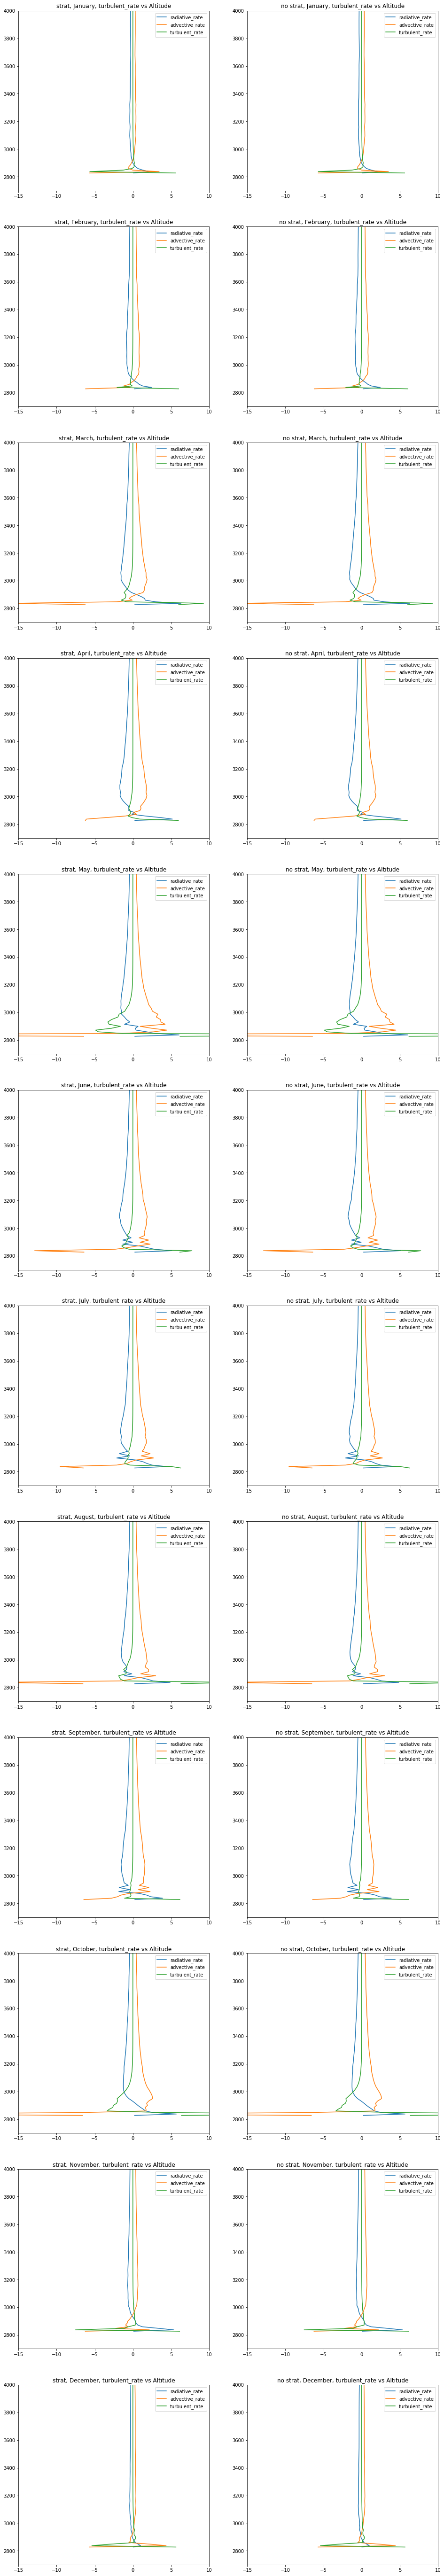

In [144]:
### plot rad/adv/turb heat flux and altitude (lower 4000 m) #####
ylim_strat_zoom = (2700,4000)
ylim_nostrat_zoom = (2700,4000)
xlims_strat_zoom = (-15,10)
xlims_nostrat_zoom = (-15,10)
fig,axs= plt.subplots(12,2,figsize=(16,100))
plot_alt('radiative_rate', ylim_strat_zoom, ylim_nostrat_zoom, xlims_strat_zoom, xlims_nostrat_zoom)
plot_alt('advective_rate', ylim_strat_zoom, ylim_nostrat_zoom, xlims_strat_zoom, xlims_nostrat_zoom)
plot_alt('turbulent_rate', ylim_strat_zoom, ylim_nostrat_zoom, xlims_strat_zoom, xlims_nostrat_zoom)

### plot monthly insolation and month
fig,ax= plt.subplots(figsize=(8,4))
plt.plot(ds_strat['month'],ds_strat['monthly_insolation'], 'ro')
plt.plot(ds_nostrat['month'],ds_nostrat['monthly_insolation'], 'bo')
plt.xticks(rotation=45);
plt.ylabel('Insolation');

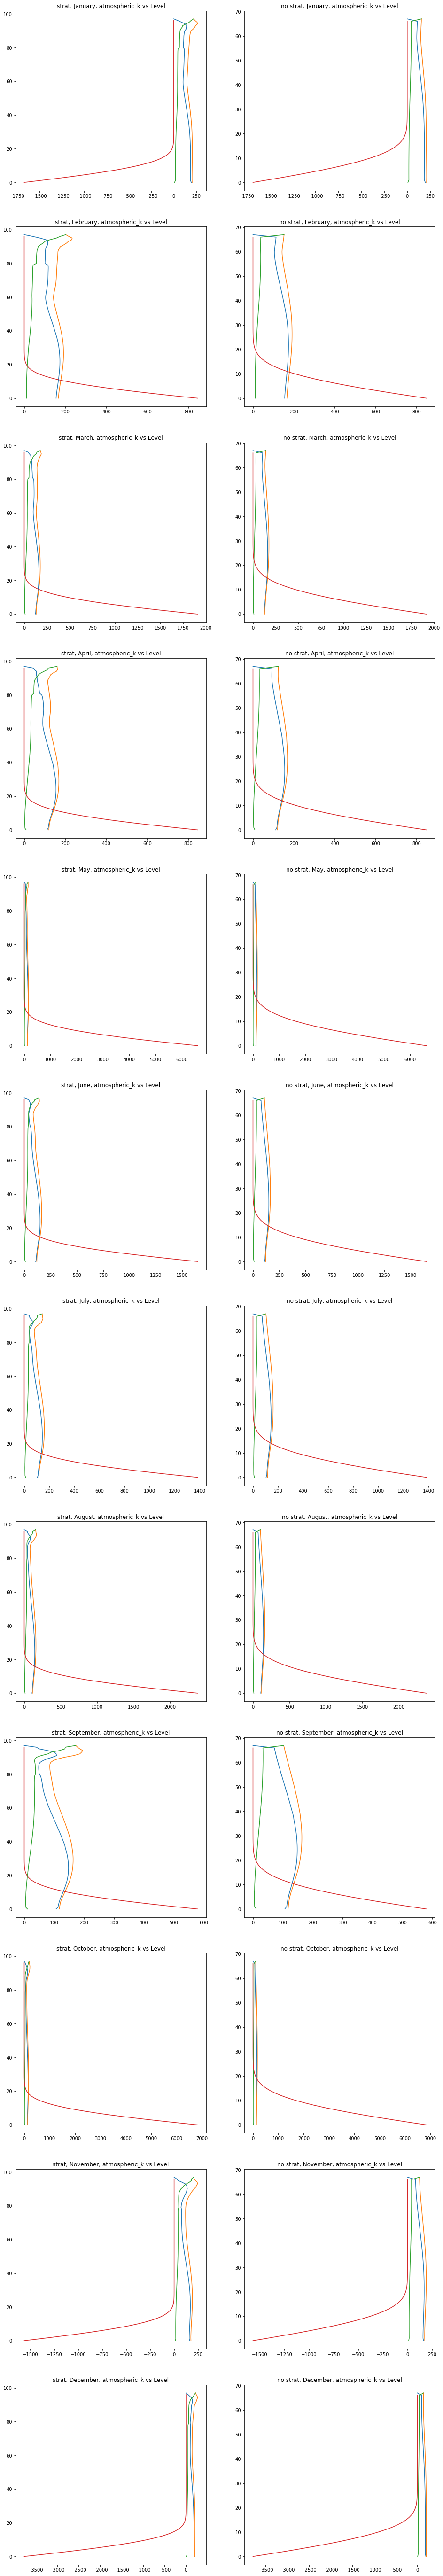

In [10]:
### plot LW radiation and level
fig,axs= plt.subplots(12,2,figsize=(16,100))
plot_level('LW_down','level_lw')
plot_level('LW_up','level_lw')
plot_level('LW_net','level_lw')
plot_level('atmospheric_k','level')